# Basic Q-Learning task

In [5]:
# imports
import numpy as np
from helpers.map import basic_map
from helpers.get_available_actions import get_available_actions
from helpers.q_matrix import q_matrix
from helpers.r_matrix import r_matrix
from helpers.random_start import random_start
from helpers.states_and_actions import states
import pandas as pd
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Graph of Environment

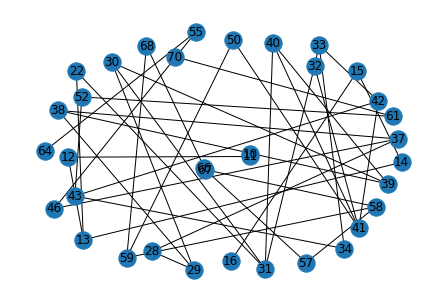

In [36]:
# using https://networkx.org/documentation/stable/tutorial.html
# initialise the graph
G = nx.Graph()
# get the states as the nodes and add the list of nodes
#G.add_nodes_from(states(basic_map()))

# get the list of states which have access to another state
r = r_matrix(basic_map())
#ns = []
#for y, row in enumerate(r):
    # check whether the state has access to anythere and if it does then add it. Otherwise don't
#    if len(get_available_actions(r, y)) > 0:
#        ns.append(y)
ns = [y for y, row in enumerate(r) if len(get_available_actions(r, y)) > 0]
G.add_nodes_from(ns)

# start iterating through the R matrix to get the connections
for y, row in enumerate(r):
    for x, cellweight in enumerate(row):
        # if the cell isn't null add the edge and the weight
        if not np.isnan(cellweight):
            G.add_edge(y, x, weight=cellweight)
# draw the graph
nx.draw(G, with_labels=True)

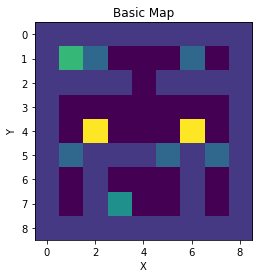

In [23]:
# Here we use imshow to show the basic map and label the axes
plt.imshow(basic_map())
plt.title('Basic Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Initialise basic environment

In [26]:
def run_q_learning_basic(alpha: float, gamma: float, epsilon: float, num_episodes: int, show_stats=True) -> dict:
    """Here we run an episode of Q-learning for the learner
    heavily influenced by Lab 4 code
    
    As it has a primary and secondary objective, I may need to stop it from repeatedly collecting the 1st reward"""
    base_map = basic_map()
    
    # States and actions
    S = states(base_map)
    
    goal_state = 10#66# 10 # TODO get programatically
    
    # R matrix
    rmat = r_matrix(base_map)
    
    # Q matrix
    Q = q_matrix(base_map)

    # Stats
    stats = {
        'num_steps': [],
        'stepPrimaryObj': [],
        'startingStep': [],
        'maxQ': [],
        'total_reward': [],
        'total_health': [],
        'q_var': []
    }
    
    # run for episodes
    for episode in range(num_episodes):
        s = random_start(base_map)
        #print(f"Starting state is {s}")
        hit_target = False
        stats['startingStep'].append(s)
        total_reward = 0
        total_health = 100
        for step in range(500):
            potential_actions = get_available_actions(rmat, s)
            
            # get the Q values for these
            q_values = [Q[s, a] for a in potential_actions]
            
            # get the best actions from the Q values
            best_actions = potential_actions[np.where(q_values == np.max(q_values))[0]]
            # get the best actions Q values
            # best_actions_q_values = [Q[s, x] for x in best_actions]
            
            # determine whether to explore or exploit
            if np.random.uniform() > epsilon:
                a = np.random.choice(potential_actions)
            else:
                a = np.random.choice(best_actions)
        
            # Get the reward
            reward = rmat[s, a]
            if reward == 50:
                if hit_target:
                    reward = 0
                else:
                    hit_target = True
                    stats['stepPrimaryObj'].append(step)
            elif reward == -10:
                # Check if it hit a trap
                total_health -= 10
            
            old_state = s
            s = a
            
            total_reward += reward

            # Update Q Value
            Q[old_state, a] = Q[old_state, a] + alpha * reward + gamma * (max(Q[s]) - Q[old_state, a])
            
            # check if goal reached
            if S[s] == goal_state or total_health <= 0:
                # print("Hit goal!")
                break
        # start filling in the statistics
        stats['num_steps'].append(step + 1)
        if not hit_target:
            stats['stepPrimaryObj'].append(-1)
        # cap the Q values statistics decimal places
        stats['maxQ'].append(Q.max().round(1))
        stats['total_reward'].append(total_reward)
        stats['total_health'].append(total_health)
        stats['q_var'].append(Q.var())
    
    if show_stats:
        #print(f"End of episode {episode} Q matrix:\n{Q.round(1)}")
        display(pd.DataFrame(Q.round(1)))
        # put the statistics using pandas
        display(pd.DataFrame.from_dict(stats))

    # return the statistics
    return {
        'alpha': alpha,
        'gamma': gamma,
        'epsilon': epsilon,
        'mean_reward': np.array(stats['total_reward']).mean(),
        'mean_total_health': np.array(stats['total_health']).mean(),
        'q_var': Q.var()
    }
run_q_learning_basic(1, 0.8, 0.9, 1000)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,num_steps,stepPrimaryObj,startingStep,maxQ,total_reward,total_health,q_var
0,500,23,34,41.7,40.0,90,1.601338e+00
1,500,123,64,52.9,10.0,60,4.283133e+00
2,21,-1,31,52.9,30.0,100,4.419600e+00
3,500,31,70,69.2,50.0,100,9.655381e+00
4,500,2,57,110.8,50.0,100,2.313267e+01
...,...,...,...,...,...,...,...
995,500,10,61,38215.2,50.0,100,1.339157e+07
996,500,11,70,38256.8,50.0,100,1.344347e+07
997,500,12,55,38297.2,50.0,100,1.347636e+07
998,500,1,68,38338.8,50.0,100,1.348077e+07


{'alpha': 1,
 'gamma': 0.8,
 'epsilon': 0.9,
 'mean_reward': 48.71,
 'mean_total_health': 99.43,
 'q_var': 13491909.718358072}

In [30]:
# Grid search
alphas = [0.0, 0.5, 1.0]
gammas = [0.7, 0.8, 0.9]
epsilons = [0.7, 0.8, 0.9]
def grid_search(fn, alphas: list, gammas: list, epsilons: list, num_episodes=1000) -> pd.DataFrame:
    """Here we loop through all of the alphas, gammas and epsilons for the function and return the concatenated returns from the function"""
    # Build a dictionary to hold the results
    ret = {
        'alpha': [],
        'gamma': [],
        'epsilon': [],
        'mean_reward': [],
        'mean_total_health': [],
        'q_var': []
    }
    # start looping
    for a in alphas:
        for g in gammas:
            for e in epsilons:
                # call the function and then pull out the results
                d = fn(a, g, e, num_episodes, show_stats=False)
                for k in d.keys():
                    ret[k].append(d[k])
    # convert the results to a dataframe
    return pd.DataFrame.from_dict(ret)
grid_search(run_q_learning_basic, alphas, gammas, epsilons, num_episodes=20)

,alpha,gamma,epsilon,mean_reward,mean_total_health,q_var
0,0.0,0.7,0.7,-35.5,30.0,0.000000
1,0.0,0.7,0.8,-58.0,19.5,0.000000
2,0.0,0.7,0.9,-61.5,13.5,0.000000
3,0.0,0.8,0.7,-68.5,12.0,0.000000
4,0.0,0.8,0.8,-34.0,35.0,0.000000
5,0.0,0.8,0.9,-47.5,24.5,0.000000
6,0.0,0.9,0.7,-72.5,9.5,0.000000
7,0.0,0.9,0.8,-38.5,28.5,0.000000
8,0.0,0.9,0.9,-36.5,33.5,0.000000
9,0.5,0.7,0.7,37.0,89.5,361.663686
